In [2]:
#importing neccessary packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#loading the dataset
from google.colab import files
uploaded = files.upload()


Saving 1805176.csv to 1805176.csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['1805176.csv']))

In [5]:
#getting the first look
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR co,2019-12-03 00:00:00,2019.0,1.930185e+09,2019-11-22,20191122,20191122,20191207.0,USD,RV,1.0,NaN,23362.84,20191122.0,NAH4,1.930185e+09,0
1,U001,0200744019,TARG foundation,2020-01-29 00:00:00,2020.0,1.930392e+09,2020-01-14,20200113,20200114,20200129.0,USD,RV,1.0,NaN,3977.47,20200114.0,NAA8,1.930392e+09,0
2,U001,0200704045,RA associates,2019-07-05 00:00:00,2019.0,1.929518e+09,2019-06-20,20190620,20190620,20190705.0,USD,RV,1.0,NaN,26230.18,20190620.0,NAA8,1.929518e+09,0
3,U001,0200793568,SUPE associates,2019-05-20 00:00:00,2019.0,1.929252e+09,2019-05-03,20190503,20190503,20190518.0,USD,RV,1.0,NaN,81606.25,20190503.0,NAA8,1.929252e+09,0
4,U001,200761734,H E BUT corporation,2019-02-05 00:00:00,2019.0,1.928652e+09,2019-01-22,20190119,20190122,20190206.0,USD,RV,1.0,NaN,15293.58,20190122.0,NAA8,1.928652e+09,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              45863 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

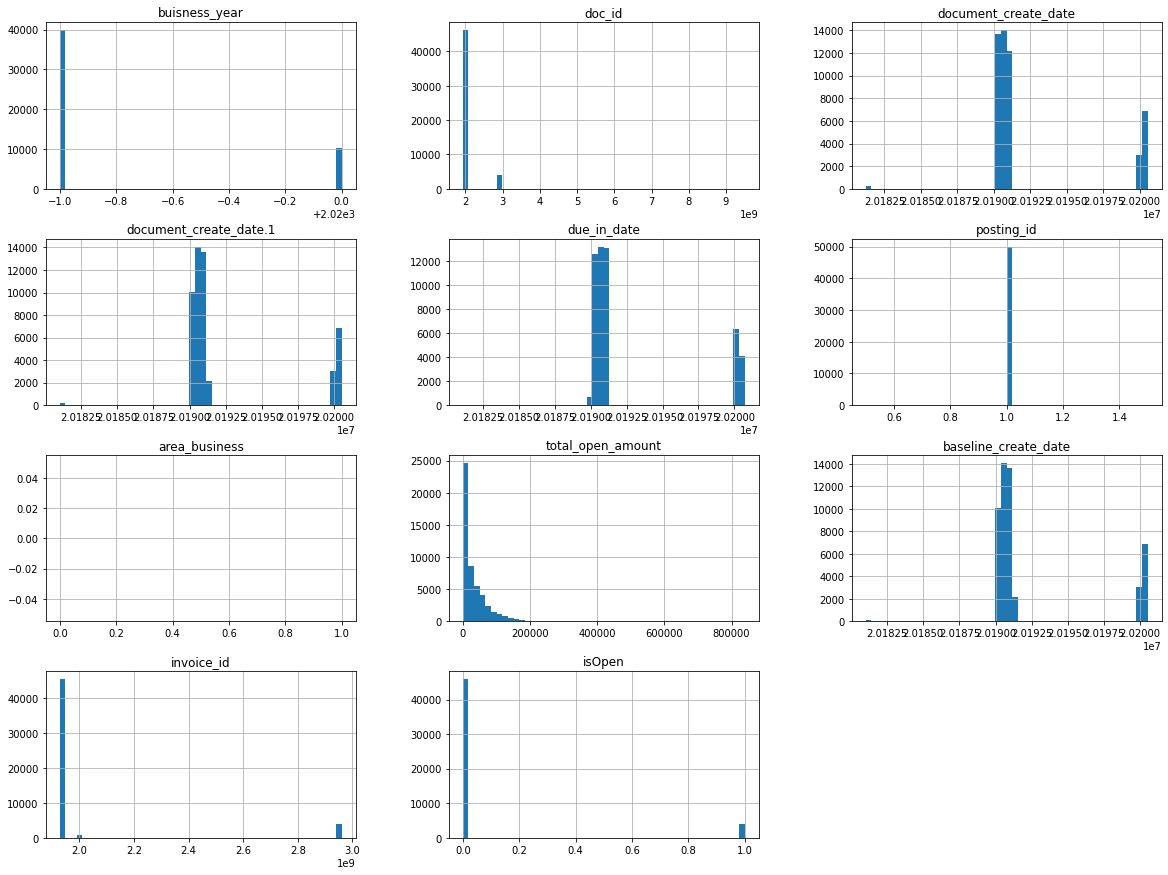

In [7]:
#getting the first visualization using matplotlib
df.hist(bins=50, figsize=(20,15))
plt.show()

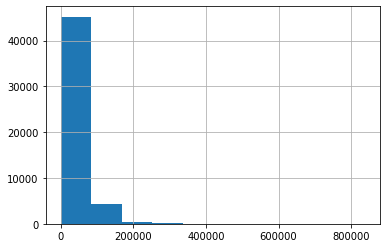

In [8]:
df['total_open_amount'].hist()

The total_amount varies very much so it cannot be capped or normalized

In [9]:
df.describe()

,buisness_year,doc_id,document_create_date,document_create_date.1,due_in_date,posting_id,area_business,total_open_amount,baseline_create_date,invoice_id,isOpen
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.0,0.0,50000.000000,5.000000e+04,4.999500e+04,50000.000000
mean,2019.203980,2.011290e+09,2.019250e+07,2.019253e+07,2.019269e+07,1.0,NaN,32073.374333,2.019253e+07,2.010541e+09,0.082740
std,0.402958,2.854703e+08,3.910243e+03,3.894120e+03,3.911997e+03,0.0,NaN,39312.408586,3.893290e+03,2.754853e+08,0.275492
min,2019.000000,1.928502e+09,2.018123e+07,2.018102e+07,2.018110e+07,1.0,NaN,0.630000,2.018102e+07,1.928502e+09,0.000000
25%,2019.000000,1.929231e+09,2.019042e+07,2.019042e+07,2.019051e+07,1.0,NaN,4731.915000,2.019042e+07,1.929231e+09,0.000000
50%,2019.000000,1.929806e+09,2.019081e+07,2.019081e+07,2.019082e+07,1.0,NaN,17187.430000,2.019081e+07,1.929805e+09,0.000000
75%,2019.000000,1.930400e+09,2.019112e+07,2.019113e+07,2.019121e+07,1.0,NaN,46391.880000,2.019113e+07,1.930400e+09,0.000000
max,2020.000000,9.500000e+09,2.020052e+07,2.020052e+07,2.020071e+07,1.0,NaN,838758.370000,2.020052e+07,2.960636e+09,1.000000


##### Feature Engineering

In [10]:
#separating the data on which the prediction is to be done.
invoice = df[(df['clear_date'].notnull() & (df['isOpen'] == 0))]
df_pred = df[(df['clear_date'].isnull() & (df['isOpen'] == 1))]

In [11]:
#formatting all date related to a similar pattern
def format_dates(data):
    data['due_in_date']=pd.to_datetime(data['due_in_date'],format='%Y%m%d')
    data['clear_date']=pd.to_datetime(data['clear_date'])
    data['posting_date']=pd.to_datetime(data['posting_date'])
    data['baseline_create_date']=pd.to_datetime(data['baseline_create_date'],format='%Y%m%d')
    data['document_create_date.1']=pd.to_datetime(data['document_create_date.1'],format='%Y%m%d')

In [12]:
format_dates(invoice)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [13]:
invoice

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR co,2019-12-03,2019.0,1.930185e+09,2019-11-22,20191122,2019-11-22,2019-12-07,USD,RV,1.0,NaN,23362.84,2019-11-22,NAH4,1.930185e+09,0
1,U001,0200744019,TARG foundation,2020-01-29,2020.0,1.930392e+09,2020-01-14,20200113,2020-01-14,2020-01-29,USD,RV,1.0,NaN,3977.47,2020-01-14,NAA8,1.930392e+09,0
2,U001,0200704045,RA associates,2019-07-05,2019.0,1.929518e+09,2019-06-20,20190620,2019-06-20,2019-07-05,USD,RV,1.0,NaN,26230.18,2019-06-20,NAA8,1.929518e+09,0
3,U001,0200793568,SUPE associates,2019-05-20,2019.0,1.929252e+09,2019-05-03,20190503,2019-05-03,2019-05-18,USD,RV,1.0,NaN,81606.25,2019-05-03,NAA8,1.929252e+09,0
4,U001,200761734,H E BUT corporation,2019-02-05,2019.0,1.928652e+09,2019-01-22,20190119,2019-01-22,2019-02-06,USD,RV,1.0,NaN,15293.58,2019-01-22,NAA8,1.928652e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45858,U001,0200714710,SYSCO us,2019-12-19,2019.0,1.930210e+09,2019-12-02,20191202,2019-12-02,2019-12-17,USD,RV,1.0,NaN,45078.76,2019-12-02,NAA8,1.930210e+09,0
45859,U001,0200126819,MCLANE co,2019-06-10,2019.0,1.929375e+09,2019-05-27,20190524,2019-05-27,2019-06-11,USD,RV,1.0,NaN,22272.33,2019-05-27,NAA8,1.929375e+09,0
45860,U001,0200020431,DEC foundation,2019-12-30,2019.0,1.930303e+09,2019-12-20,20191220,2019-12-20,2020-01-08,USD,RV,1.0,NaN,295.16,2019-12-16,NAM4,1.930303e+09,0
45861,U001,0200661137,AFFI llc,2019-01-28,2019.0,1.928594e+09,2019-01-08,20190109,2019-01-08,2019-01-28,USD,RV,1.0,NaN,46389.30,2019-01-08,NAD1,1.928594e+09,0


In [14]:
#removing faulty rows
invoice = invoice[invoice['baseline_create_date'] <= invoice['clear_date']] 
invoice = invoice[invoice['due_in_date'] >= invoice['baseline_create_date']]

In [15]:
#creating neccessary new features
def new_features(data):
    data['month_clear'] = data['clear_date'].dt.month
    data['weekday_clear'] = data['clear_date'].dt.dayofweek
    data['delay']=(data['clear_date']-data['due_in_date']).dt.days

In [16]:
#sorting on basis of document create date
invoice = invoice.sort_values(by='document_create_date.1')
invoice = invoice.reset_index()

In [17]:
new_features(invoice)

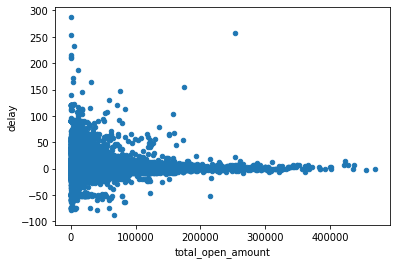

In [18]:
invoice.plot(kind='scatter',x='total_open_amount',y='delay')

As the amount of tgransaction increase the payment is done without any major delay

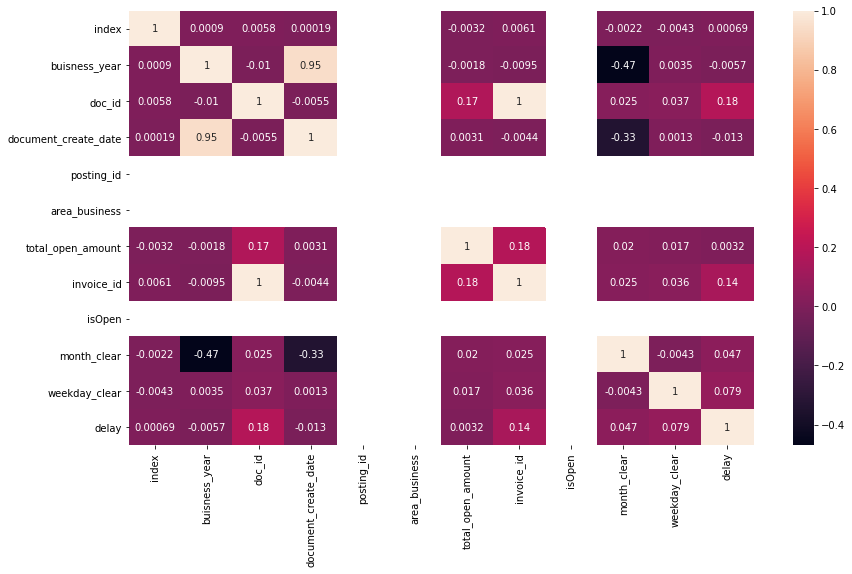

In [19]:
#checking correlation of features
corr=invoice.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr,annot=True)

In [20]:
#removing inneccessary features and highly 
invoice = invoice.drop(['posting_date','invoice_currency', 'document type','clear_date','business_code', 'cust_number', 'name_customer', 'doc_id', 'document_create_date',  'document_create_date.1', 'due_in_date', 'posting_id','area_business', 'baseline_create_date','cust_payment_terms','invoice_id','isOpen'], axis=1)


In [21]:
#removing inneccessary features and highly 
df_pred = df_pred.drop(['posting_date','invoice_currency', 'document type','clear_date','business_code', 'cust_number', 'name_customer', 'doc_id', 'document_create_date',  'document_create_date.1', 'due_in_date', 'posting_id','area_business', 'baseline_create_date','cust_payment_terms','invoice_id','isOpen'], axis=1)


In [22]:
invoice

,index,buisness_year,total_open_amount,month_clear,weekday_clear,delay
0,7928,2019.0,878.40,5,4,209
1,3429,2019.0,3239.88,1,1,1
2,13130,2019.0,20468.39,1,1,1
3,37840,2019.0,43208.29,1,3,-4
4,31570,2019.0,69688.57,1,2,-5
...,...,...,...,...,...,...
45854,28035,2020.0,47259.54,3,2,-52
45855,15376,2020.0,10990.81,3,3,-1
45856,458,2020.0,8793.09,3,3,-1
45857,23570,2020.0,53264.58,3,2,5


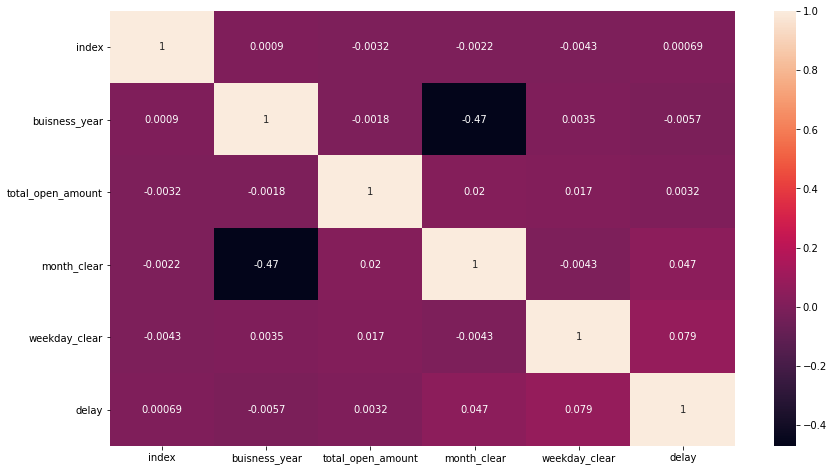

In [23]:
#checking correlation of features
corr=invoice.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr,annot=True)

In [24]:
#no high correlated features

In [25]:
#creating validation splits
train=invoice.iloc[:32102,:]
val=invoice.iloc[32103:,:]

In [26]:
val1=val.iloc[:6880,:]
val2=val.iloc[6880:,:]

In [27]:
#separating the label column
y_train = train['delay']
x_train = train.drop(['delay'], axis=1)
x_train = x_train.drop(['index'], axis=1)

In [28]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [29]:
from sklearn.metrics import mean_squared_error
forest_pred = forest_reg.predict(x_train)
forest_mse = mean_squared_error(y_train, forest_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

4.715244098805301

Fine Tuning the model (Hyperparameter tuning)

In [30]:
#using validation set1 for hyperparameter tuning
y_train_ht = val1['delay']
x_train_ht = val1.drop(['delay'], axis=1)

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 30, 50], 'max_features': [2, 4]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 50], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(x_train_ht, y_train_ht)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [32]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 50}

In [33]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [34]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

9.303961943647298 {'max_features': 2, 'n_estimators': 10}
8.54864464452687 {'max_features': 2, 'n_estimators': 30}
8.392099132448164 {'max_features': 2, 'n_estimators': 50}
9.01077762305191 {'max_features': 4, 'n_estimators': 10}
8.961260906168494 {'max_features': 4, 'n_estimators': 30}
8.871667582685593 {'max_features': 4, 'n_estimators': 50}
10.401389572492691 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
9.926776465115557 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
9.854116102759631 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
9.956999180195739 {'bootstrap': False, 'max_features': 2, 'n_estimators': 50}
13.309784194236872 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
11.87745537650764 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
10.968014808396699 {'bootstrap': False, 'max_features': 3, 'n_estimators': 30}
11.223724276188674 {'bootstrap': False, 'max_features': 3, 'n_estimators': 50}
12.18619609734709 {'bootstra

In [35]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.083200,0.004841,0.004753,0.000184,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-186.649455,-63.125094,-73.356642,-52.349273,-57.338074,-86.563708,50.528640,6,-8.800203,-9.411739,-9.074253,-10.072237,-10.624324,-9.596551,0.666890
1,0.240506,0.007059,0.012229,0.001441,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-137.014944,-60.650614,-68.864541,-48.030678,-50.835849,-73.079325,32.809168,2,-7.130807,-7.797595,-7.267458,-8.138984,-8.454185,-7.757806,0.503069
2,0.391697,0.008517,0.018259,0.001712,2,50,NaN,"{'max_features': 2, 'n_estimators': 50}",-128.325098,-59.597373,-67.853938,-47.050617,-49.309614,-70.427328,29.894784,1,-6.724818,-7.496336,-7.050181,-7.877709,-8.253425,-7.480494,0.549849
3,0.121822,0.003134,0.004723,0.000470,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-153.793169,-62.929578,-73.860821,-52.357464,-63.029535,-81.194113,36.931010,5,-9.051007,-9.500002,-9.159408,-9.982842,-11.165710,-9.771794,0.768891
4,0.349243,0.006268,0.012409,0.001780,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-169.747597,-61.537473,-70.114359,-47.479427,-52.642129,-80.304197,45.384579,4,-7.338560,-7.916790,-7.318876,-8.259468,-8.725839,-7.911907,0.541058
5,0.580095,0.016740,0.018290,0.001527,4,50,NaN,"{'max_features': 4, 'n_estimators': 50}",-165.395377,-60.264119,-69.180600,-47.354382,-51.337951,-78.706486,43.995042,3,-6.890297,-7.454763,-7.078587,-8.062857,-8.421779,-7.581656,0.580434
6,0.037034,0.001235,0.002335,0.000168,2,3,False,"{'bootstrap': False, 'max_features': 2, 'n_est...",-224.719234,-75.392361,-89.096576,-73.077762,-78.658592,-108.188905,58.522269,10,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
7,0.122993,0.005032,0.005139,0.000632,2,10,False,"{'bootstrap': False, 'max_features': 2, 'n_est...",-217.349615,-69.383009,-81.119201,-60.824811,-64.027820,-98.540891,59.804456,8,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
8,0.353037,0.003525,0.012782,0.001389,2,30,False,"{'bootstrap': False, 'max_features': 2, 'n_est...",-219.476896,-67.937783,-78.669296,-57.064750,-62.369296,-97.103604,61.604015,7,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
9,0.589303,0.012367,0.020704,0.002041,2,50,False,"{'bootstrap': False, 'max_features': 2, 'n_est...",-234.049014,-66.929443,-77.994865,-55.035869,-61.699972,-99.141833,67.870478,9,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=4),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(x_train_ht, y_train_ht)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [37]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


8.560561784085458 {'max_features': 3, 'n_estimators': 180}
8.310882276382351 {'max_features': 1, 'n_estimators': 15}
8.529598520793693 {'max_features': 3, 'n_estimators': 72}
8.24845911647956 {'max_features': 1, 'n_estimators': 21}
8.498635746174156 {'max_features': 3, 'n_estimators': 122}
8.583796829511746 {'max_features': 3, 'n_estimators': 75}
8.624280454941516 {'max_features': 3, 'n_estimators': 88}
8.26123653658289 {'max_features': 1, 'n_estimators': 100}
8.490690252419546 {'max_features': 3, 'n_estimators': 150}
9.970231855669855 {'max_features': 1, 'n_estimators': 2}


In [38]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.45610312, 0.        , 0.44608796, 0.04064974, 0.05715917])

In [39]:
final_model = rnd_search.best_estimator_

In [40]:
y_test=val2['delay']

In [41]:
x_test = val2.drop(['delay'], axis=1)

In [42]:
final_predictions = final_model.predict(x_test)

In [43]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [44]:
final_rmse

10.479936982601377

In [45]:
#trying out xgboost 

In [46]:
import xgboost as xgb

In [47]:
xg = xgb.XGBRegressor()

In [48]:
xg.fit(x_test,y_test)

[13:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [49]:
test_res = xg.predict(x_test)

In [50]:
import sklearn.metrics as sm

In [51]:
sm.mean_squared_error(y_test,test_res)

77.44197461231403

In [52]:
sq=sm.mean_squared_error(y_test,test_res)

In [53]:
sq=np.sqrt(sq)

In [54]:
sq

8.80011219316629

In [ ]:
#so using xgboost error comes out to be 8

In [ ]:
#bucketization of the delay column

In [59]:
def bucketization(data):
  if(data >= 0 and data <= 15):
    print("bucket 0")
  elif(data >= 16 and data <= 30):
    print("bucket 1")
  elif(data >= 31 and data <= 45):
    print("bucket 2")
  elif(data >= 46 and data <= 60):
    print("bucket 3")
  elif(data >= 60):
    print("bucket 4")
  else:
    print("early bucket")

In [60]:
bucketization(test_res[5])

early bucket


In [61]:
bucketization(test_res[50])

bucket 0
